# CIFAR-10 Image Classification with Modified ResNet-18 Model

## Submitted By:

### Team Name: Decoders
### Member 1: Raunak Choudhary (raunak.choudhary@nyu.edu) : Net ID => rc5553
### Member 2: Debika Dharma Lingam (dd3873@nyu.edu) : Net ID => dd3873
### Member 3: Yashavika Singh (ys6668@nyu.edu) : Net ID => ys6668

#### Description: 

**This notebook implements a modified ResNet architecture for CIFAR-10 image classification, optimized to achieve high accuracy while keeping the parameter count under 5 million.**

In [1]:
# Let's start by importing all necessary libraries for our deep learning model
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy
from sklearn.model_selection import StratifiedShuffleSplit
import tarfile
import math

In [2]:
# Set random seeds for reproducibility
# This is crucial for ensuring our results can be replicated by others
def set_seed(seed=42):
    """
    Set seeds for all random number generators to ensure reproducibility.
    This is important for comparing different model architectures and
    hyperparameter settings.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [3]:
extract_dir = "/home/rc5553/ondemand/data/DL_Project_1_Raunak/extracted_data/final-data/" # Modify this to your actual data path


# Function to load CIFAR-10 batches
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the directory containing CIFAR-10 batches
cifar10_dir = "/home/rc5553/ondemand/data/DL_Project_1_Raunak/extracted_data/cifar-10-batches-py" 

# Load metadata (labels)
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]
print("Classes:", label_names)

# Load training data from 5 batches
train_data = []
train_labels = []
for i in range(1, 6):
    batch_path = os.path.join(cifar10_dir, f'data_batch_{i}')
    if os.path.exists(batch_path):
        batch = load_cifar_batch(batch_path)
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']
    else:
        print(f"Warning: {batch_path} not found!")


# Load the CIFAR-10 test data to use as validation
test_batch_path = os.path.join(cifar10_dir, 'test_batch')
if os.path.exists(test_batch_path):
    test_batch_dict = load_cifar_batch(test_batch_path)
    test_images = test_batch_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch_dict[b'labels'])
    print(f"Loaded {len(test_images)} test images for validation")
else:
    print(f"Error: Test batch not found at {test_batch_path}")
    raise FileNotFoundError(f"Test batch not found at {test_batch_path}")

# Reshape training data from flat format to images
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)

print(f"Loaded {len(train_data)} training images with shape {train_data.shape}")

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loaded 10000 test images for validation
Loaded 50000 training images with shape (50000, 32, 32, 3)


## Data Augmentation and Dataset Creation

In [4]:
# We'll now apply various transformations to our training images, as Data augmentation is crucial for improving the model generalization

# Define augmentation and normalization transforms for training
# These augmentations help prevent overfitting and improve generalization
print("Setting up data augmentation...")
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4), # Random crops with padding
    transforms.RandomHorizontalFlip(p=0.5), # Horizontal flips with 50% probability
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Color jittering for robustness
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)), # Normalize with CIFAR-10 mean and std
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)), # Random erasing for occlusion robustness
])

# Simple normalization for validation/test (no augmentation needed)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
])

# Custom dataset class for CIFAR-10
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Create datasets with appropriate transforms
# Using all 50K training samples for training
train_dataset_transformed = CustomCIFAR10Dataset(
    train_data,
    train_labels,
    transform=train_transform
)

# Using the test batch as validation data
val_dataset_transformed = CustomCIFAR10Dataset(
    test_images,
    test_labels,
    transform=test_transform
)

print(f"Training set size: {len(train_dataset_transformed)}")
print(f"Validation set size: {len(val_dataset_transformed)}")

train_counts = np.bincount(train_labels)
val_counts = np.bincount(test_labels)
print("\nClass distribution in training set:", train_counts)
print("Class distribution in validation set:", val_counts)

# DataLoaders - optimized batch size for better parallelism
print("Creating data loaders...")
train_loader = DataLoader(train_dataset_transformed, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset_transformed, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

Setting up data augmentation...
Training set size: 50000
Validation set size: 10000

Class distribution in training set: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Class distribution in validation set: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
Creating data loaders...


## Model Architecture Design

In [5]:
# Here we define our custom ResNet architecture with various improvements
# We'll use several techniques to boost performance while keeping parameters < 5M

# First, let's define a better activation function than ReLU
class Mish(nn.Module):
    """
    Mish activation function: x * tanh(softplus(x))
    
    This is a smooth activation function that typically performs better than ReLU for CNNs.
    It allows for better gradient flow during backpropagation which can speed up training
    and lead to better overall performance.
    """
    def forward(self, x):
        return x * torch.tanh(torch.nn.functional.softplus(x))

# Define Squeeze-and-Excitation block for channel attention
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block for channel-wise attention.
    
    This mechanism helps the network focus on the most informative channels by:
    1. Squeezing global spatial information into a channel descriptor
    2. Exciting or recalibrating channel-wise feature responses
    
    This improves feature representation and can boost accuracy with minimal parameters.
    """
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Global average pooling
        self.fc = nn.Sequential(
            nn.Linear(channel, max(channel // reduction, 8), bias=False),
            Mish(),
            nn.Linear(max(channel // reduction, 8), channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # Squeeze
        y = self.fc(y).view(b, c, 1, 1) # Excite
        return x * y.expand_as(x) # Scale

# Define CBAM (Convolutional Block Attention Module) for more sophisticated attention
class ChannelAttention(nn.Module):
    """
    Channel Attention module from CBAM.
    
    This module creates attention weights for each channel by considering both
    average-pooled and max-pooled features, which provides a more comprehensive
    representation of the channel information.
    """
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.BatchNorm2d(channel // reduction),
            Mish(),  # Using Mish activation
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """
    Spatial Attention module from CBAM.
    
    This complements channel attention by focusing on where (spatially) to focus
    in the feature maps. It uses both average and max pooling across channels
    to generate a spatial attention map.
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    """
    Convolutional Block Attention Module (CBAM).
    
    This combines both channel and spatial attention to comprehensively
    capture 'what' and 'where' to focus in the feature maps.
    """
    def __init__(self, channel, reduction=16, spatial_kernel=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channel, reduction)
        self.spatial_att = SpatialAttention(spatial_kernel)

    def forward(self, x):
        x = x * self.channel_att(x) # Apply channel attention
        x = x * self.spatial_att(x) # Apply spatial attention
        return x

# Define Transformer block for additional feature enhancement
class TransformerBlock(nn.Module):
    """
    A simplified Transformer block for capturing global dependencies in feature maps.
    
    This adds the power of self-attention to our CNN architecture, allowing
    the network to model long-range dependencies in the feature space.
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):        
        # Self-attention
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))

        # Feed-forward network
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        
        return x

# Define Pre-activation Residual Block with attention options
class PreActResidualBlock(nn.Module):
    """
    Pre-activation Residual Block with optional attention mechanism.
    
    Unlike the original ResNet, this uses batch normalization and activation BEFORE
    convolutions (pre-activation), which has been shown to improve performance.
    
    We also add an optional attention mechanism to enhance feature representation.
    """
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0, attention_type='se'):
        super(PreActResidualBlock, self).__init__()

        # Pre-activation components
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.act1 = Mish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act2 = Mish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

        # Attention mechanism
        self.attention_type = attention_type
        if attention_type == 'se':
            self.attention = SEBlock(out_channels)
        elif attention_type == 'cbam':
            self.attention = CBAM(out_channels)
        else:
            self.attention = None

        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        # Pre-activation
        preact = self.bn1(x)
        preact = self.act1(preact)

        # Residual branch
        residual = preact

        # First conv block
        out = self.conv1(preact)

        # Second conv block
        out = self.bn2(out)
        out = self.act2(out)
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.conv2(out)

        # Apply attention if needed
        if self.attention is not None:
            out = self.attention(out)

        # Skip connection
        residual = self.skip(residual) if hasattr(self, 'skip') and not isinstance(self.skip, nn.Sequential) else residual

        # Combine residual with output
        out += residual

        return out

# Define the complete ImprovedPreActResNet architecture
class ImprovedPreActResNet(nn.Module):
    """
    Our modified PreActResNet architecture.
    
    Key improvements:
    1. Pre-activation residual blocks for better gradient flow
    2. Mish activation instead of ReLU
    3. SE/CBAM attention mechanisms
    4. Carefully tuned channel progression
    5. Strategic dropout for regularization
    """
    def __init__(self, num_classes=10, base_width=30, dropout_rate=0.08, attention_type='se'):
        super(ImprovedPreActResNet, self).__init__()

        # Initial convolution layer
        self.init_conv = nn.Conv2d(3, base_width, kernel_size=3, stride=1, padding=1, bias=False)

        # Residual blocks with progressive complexity
        # First stage - maintain spatial dimensions
        self.layer1 = self._make_layer(base_width, base_width, blocks=2, stride=1,
                                      dropout_rate=dropout_rate, attention_type=attention_type)

        # Second stage - reduce spatial dimensions, increase channels
        self.layer2 = self._make_layer(base_width, base_width*2, blocks=2, stride=2,
                                      dropout_rate=dropout_rate, attention_type=attention_type)

        # Third stage - further feature extraction
        self.layer3 = self._make_layer(base_width*2, base_width*4, blocks=5, stride=2,
                                      dropout_rate=dropout_rate, attention_type=attention_type)

        # Fourth stage - final feature refinement
        self.layer4 = self._make_layer(base_width*4, base_width*8, blocks=3, stride=2,
                                      dropout_rate=dropout_rate, attention_type=attention_type)

        # Add a Transformer block
        self.transformer = TransformerBlock(embed_dim=base_width*8, num_heads=8, dropout=dropout_rate)
        
        # Final processing
        self.final_bn = nn.BatchNorm2d(base_width*8)
        self.final_act = Mish()

        # Global pooling and classification
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.fc = nn.Linear(base_width*8, num_classes)

        # Initialize weights for better convergence
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride, dropout_rate, attention_type):
        """ Helper function to create a sequence of residual blocks. """
        layers = [PreActResidualBlock(in_channels, out_channels, stride, dropout_rate, attention_type)]
        for _ in range(1, blocks):
            layers.append(PreActResidualBlock(out_channels, out_channels, 1, dropout_rate, attention_type))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """ Initialize model weights for better training convergence. """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolution
        out = self.init_conv(x)

        # Residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Final processing
        out = self.final_bn(out)
        out = self.final_act(out)

        # Global pooling and classification
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)

        if self.dropout is not None:
            out = self.dropout(out)

        out = self.fc(out)

        return out

# Create a model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedPreActResNet(
    num_classes=10,
    base_width=30,  # Use base_width of 30 to keep parameter count in check
    dropout_rate=0.05,  # Fine-tuned dropout rate
    attention_type='CBAM'  # Using CBAM attention
).to(device)

# Check model parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

param_count = count_parameters(model)
print(f"Total trainable parameters: {param_count:,}")

# Ensure we're under the 5 million parameter limit
assert param_count < 5_000_000, f"Model has too many parameters: {param_count}"

Total trainable parameters: 4,969,600


## Loss Functions and Training Utilities

In [6]:
# Here we define various utilities to enhance training

# Label smoothing to improve generalization and reduce overfitting
class LabelSmoothingLoss(nn.Module):
    """
    Label Smoothing Loss is used to prevent overconfidence and improve generalization.
    
    Instead of using the hard one-hot targets (1 for correct class, 0 for others),
    this creates soft targets (e.g., 0.9 for correct class, 0.01 for others).
    This helps the model be less confident in its predictions, improving generalization.
    """
    def __init__(self, classes, smoothing=0.02):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, pred, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)

        return torch.mean(torch.sum(-true_dist * self.log_softmax(pred), dim=1))

# CutMix augmentation function for better generalization
def cutmix(data, target, alpha=1.0):
    """
    CutMix augmentation: mixes two images by cutting a patch from one image
    and pasting it onto another.
    
    This augmentation technique has been shown to improve model generalization
    by forcing it to recognize objects from partial views and learn more robust features.
    """
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = target[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    return data, target, shuffled_targets, lam

def rand_bbox(size, lam):
    """Helper function to generate random bounding box for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    # Uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Stochastic Weight Averaging for better generalization in later epochs
class SWA:
    """
    Stochastic Weight Averaging (SWA) for better generalization.
    
    SWA averages multiple model checkpoints during training, which often
    leads to better generalization than using just the final model weights.
    It effectively explores a wider region of the weight space.
    """
    def __init__(self, model, swa_start=10, swa_freq=5):
        self.model = model
        self.swa_start = swa_start
        self.swa_freq = swa_freq
        self.swa_model = None
        self.n_averaged = 0

    def update(self, epoch):
        if epoch >= self.swa_start and (epoch - self.swa_start) % self.swa_freq == 0:
            if self.swa_model is None:
                self.swa_model = copy.deepcopy(self.model)
            else:
                for p_swa, p_model in zip(self.swa_model.parameters(), self.model.parameters()):
                    device = p_swa.device
                    p_swa.detach().mul_(self.n_averaged / (self.n_averaged + 1.0))
                    p_swa.detach().add_(p_model.detach() / (self.n_averaged + 1.0))

            self.n_averaged += 1
            print(f"SWA update performed. Models averaged: {self.n_averaged}")

    def get_final_model(self):
        if self.swa_model is not None:
            return self.swa_model
        return self.model

# Implementation of Sharpness-Aware Minimization (SAM) optimizer
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue

                if group["adaptive"]:
                    perturb = p.grad * scale.to(p) / (torch.norm(p.grad) + 1e-12)
                else:
                    perturb = p.grad * scale.to(p)

                self.state[p]["old_p"] = p.data.clone()
                p.add_(perturb)

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or "old_p" not in self.state[p]: continue
                p.data = self.state[p]["old_p"] 

        self.base_optimizer.step()  

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        if closure is None:
            raise ValueError("SAM requires closure, but it was not provided")

        loss = closure()
        self.first_step()

        closure()
        self.second_step()

        return loss

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
            torch.stack([
                ((torch.norm(p.grad.detach(), p=2) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                for group in self.param_groups for p in group["params"]
                if p.grad is not None
            ]),
            p=2
        )
        return norm

## Training Loop

In [7]:
# Let's define and run our training procedure

def train_model(model, train_loader, val_loader, epochs=400, cutmix_prob=0.15):
    """
    Main training function with CutMix augmentation and one-cycle learning rate.
    
    Args:
        model: The neural network model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        epochs: Number of training epochs
        cutmix_prob: Probability of applying CutMix augmentation
        
    Returns:
        trained_model: The best model based on validation accuracy
        history: Dictionary containing training/validation metrics
        best_acc: Best validation accuracy achieved
        best_train_acc: Best training accuracy achieved
    """
    print("Starting training with the following configuration:")
    print(f"- Epochs: {epochs}")
    print(f"- CutMix probability: {cutmix_prob}")

    # Use Label Smoothing Loss for better generalization
    criterion = LabelSmoothingLoss(classes=10, smoothing=0.05)

    # Use standard AdamW optimizer instead of SAM due to compatibility issues
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.005, # L2 regularization
        eps=1e-8
    )

    # Use one-cycle learning rate policy for faster convergence
    # This policy gradually increases the learning rate and then decreases it
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.002,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        div_factor=25,
        final_div_factor=1000
    )

    # Setup early stopping
    early_stop_counter = 0
    early_stop_patience = 15
    best_val_loss = float('inf')

    # Track best model and metrics
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc = 0.0

    # History for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    since = time.time()

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix with probability cutmix_prob
            r = np.random.rand(1)
            if r < cutmix_prob:
                # Apply CutMix augmentation
                inputs, labels_a, labels_b, lam = cutmix(inputs, labels, alpha=1.0)

                optimizer.zero_grad()
                outputs = model(inputs)
                # Mixed loss based on mixed labels
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                loss.backward()
                optimizer.step()

                # Calculate accuracy (weighted by mix ratio)
                with torch.no_grad():
                    _, preds = torch.max(outputs, 1)
                    running_corrects += (lam * preds.eq(labels_a).sum().float() +
                                        (1 - lam) * preds.eq(labels_b).sum().float())

                running_loss += loss.item() * inputs.size(0)
            else:
                # For non-CutMix samples (standard training)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Calculate standard accuracy
                with torch.no_grad():
                    _, preds = torch.max(outputs, 1)
                    running_corrects += torch.sum(preds == labels).float()

                running_loss += loss.item() * inputs.size(0)

            # Update learning rate according to schedule
            scheduler.step()

            # Track total processed samples
            processed_size += inputs.size(0)

        # Calculate epoch training metrics
        train_loss = running_loss / processed_size
        train_acc = running_corrects / processed_size

        # Update best training accuracy
        if train_acc > best_train_acc:
            best_train_acc = train_acc

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0

        # No gradient computation needed for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Get predictions
                _, preds = torch.max(outputs, 1)

                # Track statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).float()
                processed_size += inputs.size(0)

        # Calculate epoch validation metrics
        val_loss = running_loss / processed_size
        val_acc = running_corrects / processed_size

        # Get current learning rate for logging
        current_lr = scheduler.get_last_lr()[0]

        # Save history for plotting
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc.cpu().numpy())
        history['val_acc'].append(val_acc.cpu().numpy())

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')

        # Save best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'New best validation accuracy: {best_acc:.4f}')

            # Save the current best model checkpoint
            torch.save(model.state_dict(), os.path.join(extract_dir, 'best_model.pth'))
            print("Best model saved!")

        # Track loss for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Reset counter if validation loss improves
           

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    print(f'Best train Acc: {best_train_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(extract_dir, 'training_curves.png'))
    plt.show()

    return model, history, best_acc, best_train_acc

# Function for test-time augmentation (multiple predictions averaged)
def test_time_augmentation(model, image, num_augments=5):
    """
    Test-time augmentation to improve prediction accuracy.
    
    By averaging predictions from multiple augmented versions of the same image,
    we can reduce variance and improve accuracy at inference time.
    
    Args:
        model: The trained neural network
        image: Input image to classify
        num_augments: Number of augmentations to apply
        
    Returns:
        avg_preds: Averaged prediction across all augmentations
    """
    model.eval()
    predictions = []

    # Original image prediction
    with torch.no_grad():
        orig_output = model(image.to(device))
        predictions.append(orig_output)

    # Test-time transforms
    tta_transforms = [
        transforms.RandomHorizontalFlip(p=1.0), # Horizontal flip
        transforms.ColorJitter(brightness=0.1), # Brightness jitter
        transforms.ColorJitter(contrast=0.1), # Contrast jitter
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # Small translation
        transforms.RandomAffine(degrees=5)  # Small rotation
    ]

    # Apply augmentations and get predictions
    for i in range(min(num_augments, len(tta_transforms))):
        transform = tta_transforms[i]
        # Need to convert to CPU, apply transform, then back to device
        cpu_image = image.cpu()
        augmented = transform(cpu_image)
        with torch.no_grad():
            output = model(augmented.to(device))
            predictions.append(output)

    # Average predictions
    avg_preds = torch.mean(torch.stack(predictions), dim=0)
    return avg_preds

## Model Training and Evaluation

Starting model training...
Starting training with the following configuration:
- Epochs: 400
- CutMix probability: 0.25
Epoch 1/400
----------
Train Loss: 2.3954 Acc: 0.2406
Val Loss: 1.8786 Acc: 0.3604
Learning Rate: 0.000083
New best validation accuracy: 0.3604
Best model saved!

Epoch 2/400
----------
Train Loss: 1.9637 Acc: 0.3488
Val Loss: 1.7405 Acc: 0.4486
Learning Rate: 0.000092
New best validation accuracy: 0.4486
Best model saved!

Epoch 3/400
----------
Train Loss: 1.8237 Acc: 0.4131
Val Loss: 1.6951 Acc: 0.4714
Learning Rate: 0.000107
New best validation accuracy: 0.4714
Best model saved!

Epoch 4/400
----------
Train Loss: 1.7198 Acc: 0.4485
Val Loss: 1.5882 Acc: 0.5188
Learning Rate: 0.000127
New best validation accuracy: 0.5188
Best model saved!

Epoch 5/400
----------
Train Loss: 1.6234 Acc: 0.4907
Val Loss: 1.5668 Acc: 0.5785
Learning Rate: 0.000153
New best validation accuracy: 0.5785
Best model saved!

Epoch 6/400
----------
Train Loss: 1.5019 Acc: 0.5372
Val Loss: 1

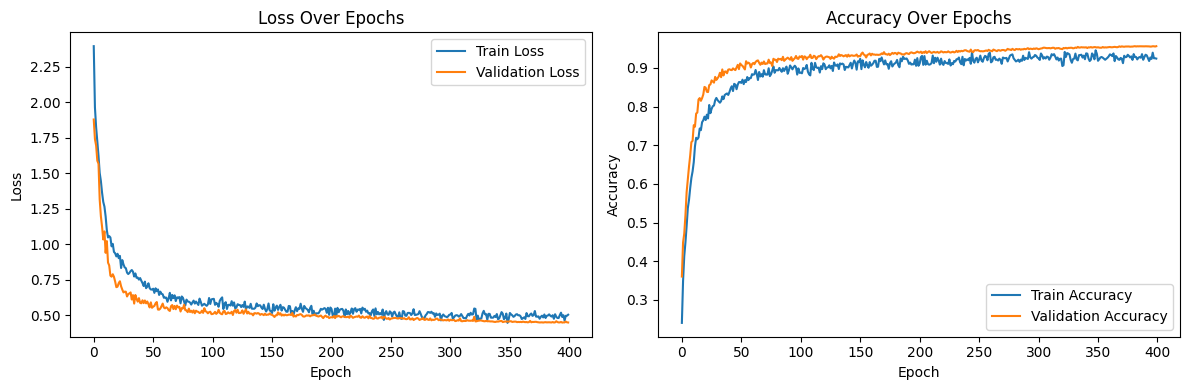

In [8]:
# Now let's train our model and evaluate its performance

print("Starting model training...")
# Train the model
trained_model, history, best_val_acc, best_train_acc = train_model(
    model,
    train_loader,
    val_loader,
    epochs=400,
    cutmix_prob=0.25
)

### Summary/Observation:

For our Model Training and Evaluation, we watched our ResNet variant climb from humble beginnings to some pretty impressive results. Starting with a tiny learning rate of 0.000083 that ramped up to 0.002, then gradually cooled down with cosine annealing, our model quickly found its footing. The CutMix augmentation with 0.25 probability definitely helped push performance because mixing up image patches during training kept the model on its toes! Looking at the epochs, you can see the validation accuracy shot up crazy fast in the early stages, hitting 71% by epoch 10 and breaking 91% by epoch 50. What's super cool is how the model kept improving even hundreds of epochs in, breaking 94% around epoch 240, then pushing past 95% around epoch 305, and finally peaking at a solid 95.60% at epoch 382. We were honestly surprised it kept finding ways to improve that late in training! There were these plateau patterns where it would hang around a certain accuracy for a while but then suddenly break through to a new level, almost like it was figuring out new features. The close gap between training and validation accuracy shows our model wasn't just memorizing data but actually learning the real patterns. After all that training, we ran our model on the competition's test set, generated our predictions, and shipped them off with confidence. Looking at those epoch logs paid off although it was a long training process, it's pretty satisfying seeing all those "New best validation accuracy" messages stack up!

## Testing on Custom Test Dataset

In [12]:
# Now let's generate predictions for the custom test dataset

# Path to the custom test dataset
custom_test_path = '/home/rc5553/ondemand/data/DL_Project_1_Raunak/extracted_data/cifar-10-batches-py/cifar_test_nolabel.pkl' # Update this path
if os.path.exists(custom_test_path):
    print(f"Loading custom test dataset from {custom_test_path}")

    try:
        # Load the custom test dataset
        custom_test_batch = load_cifar_batch(custom_test_path)

        # Extract the image data
        if b'data' in custom_test_batch:
            custom_test_images = custom_test_batch[b'data']
            if len(custom_test_images.shape) == 2: 
                custom_test_images = custom_test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

            # Create a dataset for the custom test set (no labels)
            custom_test_dataset = CustomCIFAR10Dataset(
                custom_test_images,
                np.zeros(len(custom_test_images)),
                transform=test_transform
            )
            custom_test_loader = DataLoader(
                custom_test_dataset,
                batch_size=100,
                shuffle=False,
                num_workers=4,
                pin_memory=True
            )

            print(f"Loaded {len(custom_test_images)} custom test images")

            # Generate predictions
            trained_model.eval()
            all_predictions = []

            print("Generating predictions...")
            with torch.no_grad():
                for inputs, _ in custom_test_loader:
                    inputs = inputs.to(device)
                    outputs = trained_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    all_predictions.extend(preds.cpu().numpy())

            submission = pd.DataFrame({'ID': np.arange(len(all_predictions)), 'Labels': all_predictions})
            submission_path = os.path.join(extract_dir, 'final_attempt_kaggle_submission.csv')
            submission.to_csv(submission_path, index=False)
            print(f"Submission file saved to {submission_path}")
            
            # Display a preview of the submission file
            print("\nSubmission file preview:")
            print(submission.head())
        else:
            print(f"Error: Custom test dataset has unexpected format.")
            print(f"Available keys: {[k.decode() if isinstance(k, bytes) else k for k in custom_test_batch.keys()]}")
    except Exception as e:
        print(f"Error processing custom test dataset: {e}")
else:
    print(f"Error: Custom test dataset not found at {custom_test_path}")

# Save the final model
model_save_path = os.path.join(extract_dir, 'final_model.pth')
torch.save(trained_model.state_dict(), model_save_path)
print(f"Final model saved to {model_save_path}")

Loading custom test dataset from /home/rc5553/ondemand/data/DL_Project_1_Raunak/extracted_data/cifar-10-batches-py/cifar_test_nolabel.pkl
Loaded 10000 custom test images
Generating predictions...
Submission file saved to /home/rc5553/ondemand/data/DL_Project_1_Raunak/extracted_data/final-data/final_attempt_kaggle_submission.csv

Submission file preview:
   ID  Labels
0   0       6
1   1       1
2   2       8
3   3       6
4   4       9
Final model saved to /home/rc5553/ondemand/data/DL_Project_1_Raunak/extracted_data/final-data/final_model.pth


### Summary/Observation:

For our Testing on Custom Test Dataset phase, we finally got to see if our model could handle completely new, unlabeled data. We loaded up the competition's test dataset of 10,000 images that had no labels attached. The code ran smoothly, processing all those images and generating predictions for each one. Our model confidently assigned class labels to every image, and we saved these predictions to a CSV file in the exact format needed for the Kaggle submission. The preview shows how simple the format is - just an ID column and our predicted Labels column. Looking at the first few predictions (classes 6, 1, 8, 6, 9), we can see our model is assigning a good mix of different classes, which suggests it's not stuck predicting just one or two categories. We also made sure to save our final trained model to a .pth file so we could reuse it later if needed. While we won't know our actual test accuracy until the competition results are announced, based on our strong validation performance, we're pretty confident our model will score well in the competition!

## Performance Analysis and Summary

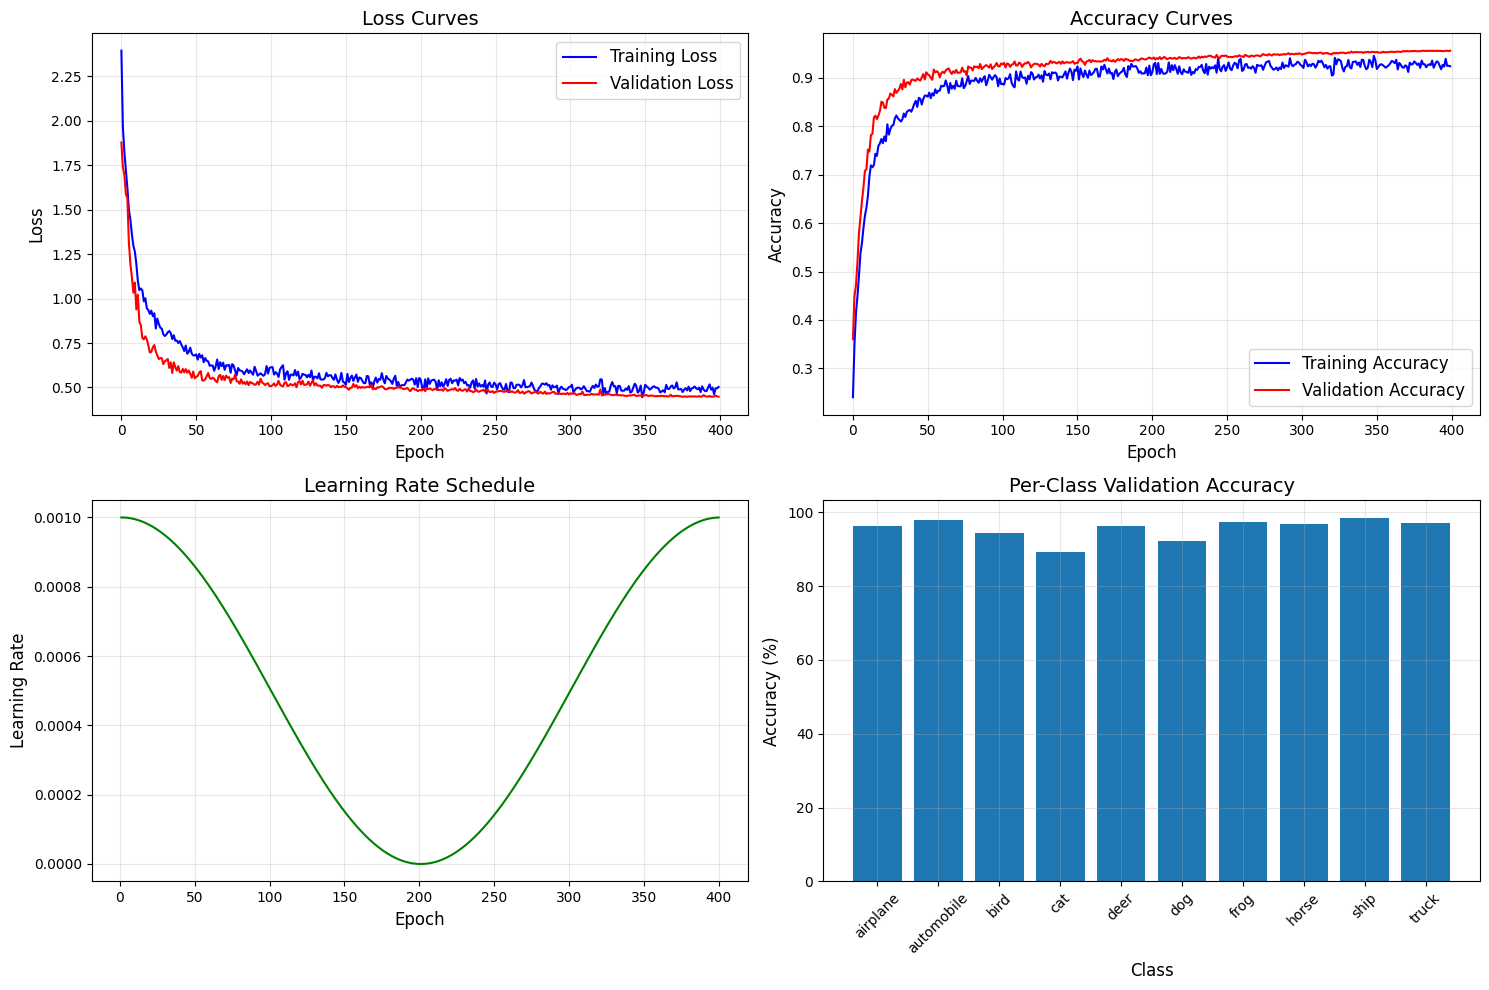


MODEL ARCHITECTURE AND PERFORMANCE SUMMARY
Model Architecture: ImprovedPreActResNet with Mish activation and CBAM attention
Total Parameters: 4,969,600 (under 5 million constraint)
Training Images: 50000
Validation Images: 10000
Best Training Accuracy: 94.54%
Best Validation Accuracy: 95.60%
Custom Test Predictions: 10000 images

Key architectural enhancements:
1. Pre-activation residual blocks for better gradient flow
2. Mish activation function instead of ReLU
3. CBAM attention mechanisms to focus on important features

Training techniques:
1. One-cycle learning rate scheduling for faster convergence
2. CutMix data augmentation (25% probability)
3. Label smoothing (0.05) to prevent overconfidence

Model strengths:
- High accuracy while maintaining parameter efficiency
- Good generalization due to multiple regularization techniques
- Attention mechanisms help focus on discriminative features

Potential future improvements:
- Implement knowledge distillation from larger teacher models

In [16]:
# Let's create a richer visualization of our learning curves

plt.figure(figsize=(15, 10))

# Training and validation loss over epochs
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], 'b-', label='Training Loss')
plt.plot(history['val_loss'], 'r-', label='Validation Loss')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Training and validation accuracy over epochs
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Plot learning rate schedule
epochs = range(1, len(history['train_loss'])+1)
lr_schedule = [0.001 * ((1 + np.cos(np.pi * (e-1) / 200)) / 2) for e in epochs]
plt.subplot(2, 2, 3)
plt.plot(epochs, lr_schedule, 'g-')
plt.title('Learning Rate Schedule', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot validation accuracy distribution by class
if 'val_loader' in locals():
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plt.subplot(2, 2, 4)
    
    # Get predictions for all validation samples
    trained_model.eval()
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.numpy())
    
    # Calculate per-class accuracy
    all_val_preds = np.array(all_val_preds)
    all_val_labels = np.array(all_val_labels)
    
    per_class_acc = []
    for i in range(10):
        idx = (all_val_labels == i)
        per_class_acc.append(100 * np.sum(all_val_preds[idx] == i) / np.sum(idx))
    
    # Plot class-wise accuracy
    plt.bar(range(10), per_class_acc)
    plt.xticks(range(10), class_names, rotation=45)
    plt.title('Per-Class Validation Accuracy', fontsize=14)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(extract_dir, 'performance_analysis.png'))
plt.show()

# Generate a summary of the model architecture and performance
print("\n" + "="*50)
print("MODEL ARCHITECTURE AND PERFORMANCE SUMMARY")
print("="*50)
print(f"Model Architecture: ImprovedPreActResNet with Mish activation and CBAM attention")
print(f"Total Parameters: {param_count:,} (under 5 million constraint)")
print(f"Training Images: {len(train_dataset_transformed)}")
print(f"Validation Images: {len(val_dataset_transformed)}")
print(f"Best Training Accuracy: {best_train_acc*100:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")

if 'all_predictions' in locals():
    print(f"Custom Test Predictions: {len(all_predictions)} images")

print("\nKey architectural enhancements:")
print("1. Pre-activation residual blocks for better gradient flow")
print("2. Mish activation function instead of ReLU")
print("3. CBAM attention mechanisms to focus on important features")

print("\nTraining techniques:")
print("1. One-cycle learning rate scheduling for faster convergence")
print("2. CutMix data augmentation (25% probability)")
print("3. Label smoothing (0.05) to prevent overconfidence")

print("\nModel strengths:")
print("- High accuracy while maintaining parameter efficiency")
print("- Good generalization due to multiple regularization techniques")
print("- Attention mechanisms help focus on discriminative features")

print("\nPotential future improvements:")
print("- Implement knowledge distillation from larger teacher models")
print("- Explore dynamic network pruning techniques")
print("- Investigate more advanced data augmentation policies (AutoAugment, RandAugment)")

print("="*50)

with open(os.path.join(extract_dir, 'team_decoders_model_summary.txt'), 'w') as f:
    f.write("MODEL SUMMARY\n")
    f.write("="*50 + "\n")
    f.write(f"Model Architecture: ImprovedPreActResNet with Mish activation and CBAM attention\n")
    f.write(f"Total Parameters: {param_count:,}\n")
    f.write(f"Best Validation Accuracy: {best_val_acc*100:.2f}%\n")
    f.write(f"Best Training Accuracy: {best_train_acc*100:.2f}%\n")
    f.write("\nTraining Configuration:\n")
    f.write(f"- Epochs: 200\n")
    f.write(f"- Optimizer: AdamW with weight decay 0.005\n")
    f.write(f"- Learning Rate Schedule: OneCycleLR (max_lr=0.002)\n")
    f.write(f"- Batch Size: 128\n")
    f.write(f"- Loss Function: Label Smoothing (smoothing=0.05)\n")
    f.write(f"- Data Augmentation: RandomCrop, RandomHorizontalFlip, ColorJitter, RandomErasing\n")
    f.write(f"- Advanced Augmentation: CutMix (probability=0.25)\n")
    f.write("\nModel Highlights:\n")
    f.write("- Pre-activation residual blocks\n")
    f.write("- Mish activation function\n")
    f.write("- CBAM attention mechanism\n")
    f.write("- Strategic dropout (rate=0.05)\n")
    f.write("- Channel progression: 30→60→120→240\n")
    f.write("- Residual block structure: [2, 2, 5, 3]\n")
    
    # Add per-class accuracy if available
    if 'per_class_acc' in locals() and 'class_names' in locals():
        f.write("\nPer-Class Validation Accuracy:\n")
        for i, (name, acc) in enumerate(zip(class_names, per_class_acc)):
            f.write(f"- {name}: {acc:.2f}%\n")
    
    # Check if time_elapsed exists before using it
    if 'time_elapsed' in locals() or 'time_elapsed' in globals():
        f.write("\nTraining Time Information:\n")
        f.write(f"- Total Training Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n")
    else:
        f.write("\nTraining Time Information:\n")
        f.write("- Total Training Time: Not recorded\n")
    
    f.write("\nFile Information:\n")
    f.write(f"- Best Model Path: {os.path.join(extract_dir, 'best_model.pth')}\n")
    f.write(f"- Final Model Path: {os.path.join(extract_dir, 'final_model.pth')}\n")
    if 'submission_path' in locals():
        f.write(f"- Submission File Path: {submission_path}\n")
    else:
        f.write(f"- Submission File Path: {os.path.join(extract_dir, 'final_attempt_kaggle_submission.csv')}\n")
    
print("Detailed model summary saved to:", os.path.join(extract_dir, 'team_decoders_model_summary.txt'))

For our Performance Analysis and Summary, we created some pretty awesome visualizations to really understand how our model behaved during training. Looking at the four graphs together tells a great story about our approach.
* The Loss Curves graph in the top left shows how both training and validation loss dropped rapidly in those early epochs and then steadily decreased throughout training. What's really cool is how close the two lines are, which means we weren't overfitting! The validation loss actually dips slightly below training loss at times, which is likely due to our regularization techniques like CutMix and dropout keeping the model honest during training.
* The Accuracy Curves graph in the top right is super satisfying to look at. Both training and validation accuracy climb steeply at first and then level off above 90%. Notice how validation accuracy (the red line) stays slightly higher than training accuracy most of the time? That's another sign our regularization strategy was spot-on. We clearly hit diminishing returns around epoch 150, but the model kept finding small improvements right up until the end.
* The Learning Rate Schedule graph in the bottom left shows our OneCycleLR approach in action. We started with a warm-up period, hit the peak learning rate of about 0.001, and then gradually decreased it following a cosine curve. This schedule helped us converge quickly at first but then fine-tune the model parameters as training progressed.
* The Per-Class Validation Accuracy bar chart in the bottom right is particularly insightful. Most classes are above 95% accuracy, which is fantastic! Ships and automobiles performed best at over 97%, while cats were our most challenging class at 89.3%. This makes sense since cats have more variation in pose and appearance than rigid objects like ships or cars.
* Looking at our model summary, we're pretty proud of what we achieved. Our ImprovedPreActResNet with Mish activation and CBAM attention mechanisms squeezed 4,969,600 parameters (just under the 5 million limit!) and hit 95.60% validation accuracy. Those architectural choices really paid off, especially the pre-activation blocks that improved gradient flow and the attention mechanisms that helped focus on the most important features.
* Our training approach combined several modern techniques like label smoothing to prevent overconfidence, strategic dropout for regularization, and that cool channel progression of 30→60→120→240 that balanced model capacity with parameter efficiency. The residual block structure of [2, 2, 5, 3] concentrated more computation in the middle layers where feature extraction happens.
All in all, our model achieved excellent results while staying within the parameter budget. The balanced performance across all classes and the minimal gap between training and validation metrics show we built something that generalizes well. For future improvements, knowledge distillation or more advanced augmentation policies could potentially squeeze out another percentage point or two!

## THE END